In [1]:
import numpy as np
import scipy.io
import skimage
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('image', cmap='gray') # set default image colormap to gray

# try gaussian weighting of neighboring patches?

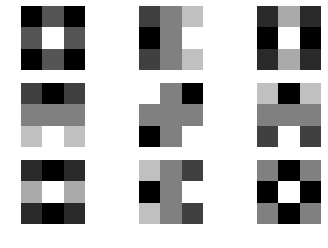

In [2]:
# 3x3 Laws filters from [Saxena et al. 2007]
L3 = np.array([1, 2, 1]) / 128 / .2
E3 = [-1, 0, 1]
S3 = [-1, 2, -1]

L3L3 = np.outer(L3, L3)
L3E3 = np.outer(L3, E3)
L3S3 = np.outer(L3, S3)
E3L3 = np.outer(E3, L3)
E3E3 = np.outer(E3, E3)
E3S3 = np.outer(E3, S3)
S3L3 = np.outer(S3, L3)
S3E3 = np.outer(S3, E3)
S3S3 = np.outer(S3, S3)

f, ax = plt.subplots(3, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(L3L3)
ax[0, 1].imshow(L3E3)
ax[0, 2].imshow(L3S3)
ax[1, 0].imshow(E3L3)
ax[1, 1].imshow(E3E3)
ax[1, 2].imshow(E3S3)
ax[2, 0].imshow(S3L3)
ax[2, 1].imshow(S3E3)
ax[2, 2].imshow(S3S3)

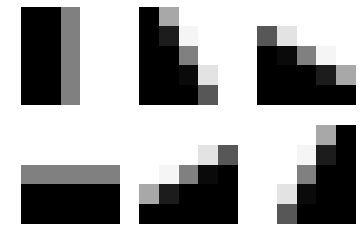

In [3]:
# Oriented edge filters from [Nevatia 1980]
NB0 = np.tile([-100, -100, 0, 100, 100], (5, 1)) / 2000
NB30 = np.array([
    [-100, 32, 100, 100, 100],
    [-100, -78, 92, 100, 100],
    [-100, -100, 0, 100, 100],
    [-100, -100, -92, 78, 100],
    [-100, -100, -100, -32, 100],
]) / 2000

NB60 = -NB30.T
NB90 = -NB0.T
NB120 = -np.flipud(NB60)
NB150 = NB120.T

f, ax = plt.subplots(2, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(NB0)
ax[0, 1].imshow(NB30)
ax[0, 2].imshow(NB60)
ax[1, 0].imshow(NB90)
ax[1, 1].imshow(NB120)
ax[1, 2].imshow(NB150)

In [4]:
import os
from urllib.request import urlretrieve

DATA_URL = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
DATA_FILE = 'nyu_depth_v2_labeled.mat'

if not os.path.isfile(DATA_FILE):
    urlretrieve('http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat', DATA_FILE)

In [11]:
import h5py

TEST_RATIO = 0.2

nyu = h5py.File(DATA_FILE, 'r')
count, channels, width, height = np.shape(nyu['images'])
test_count = int(count * TEST_RATIO)
test_indices = sorted(perm[:test_count])
train_indices = sorted(perm[test_count:])

WIDTH=640
HEIGHT=480
CHANNELS=3

In [144]:
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import normalize

class NYUSequence(Sequence):
    def __init__(self, ids, batch_size, images, depths, shuffle=True):
        self.batch_size = batch_size
        self.state = np.random.RandomState(seed=0xbeef)
        self.images = images
        self.depths = depths
        
        self.ids = ids
        
        if shuffle:
            self.perm = self.state.permutation(len(self.ids))
        else:
            self.perm = np.arange(len(self.ids))
        
    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        init_ids = self.perm[index * self.batch_size : (index + 1) * self.batch_size]
        perm_ids = [self.ids[i] for i in init_ids]
        X, y = self._generate(perm_ids)
        return X, y
    
    def on_epoch_end(self):
        self.perm = self.state.permutation(len(self.ids))
        
    def _generate(self, ids):
        X = np.empty((self.batch_size, CHANNELS, WIDTH, HEIGHT))
        y = np.empty((self.batch_size, 1, WIDTH, HEIGHT))
        
        for i in range(self.batch_size):
            X[i,] = self.images[ids[i]] / 255.0
            
            # add a channel axis to y to match the dimensions of X and normalize it
            y[i] = np.expand_dims(self.depths[ids[i]] / np.max(self.depths[ids[i]]), 0)
        
        return X, y
        

In [110]:
import tensorflow.keras.backend as K

W = 640
H = 480
N = np.float32(W * H)

# see https://papers.nips.cc/paper/5539-depth-map-prediction-from-a-single-image-using-a-multi-scale-deep-network.pdf
#
# this can be augmented with a gradient term! https://arxiv.org/pdf/1411.4734.pdf
def scale_invariant_loss(y_true, y_pred):
    D = K.log(y_pred)
    D_star = K.log(y_true)
    d = D - D_star
    
    loss = (1 / N) * K.sum(K.pow(d, 2)) - (1 / K.pow(N, 2)) * K.pow(K.sum(d), 2)
    return loss

In [145]:
# Adapted from [Ma, Geng, Bie 2017] pure CNN network

from tensorflow.keras.layers import BatchNormalization, Conv2D, Input
from tensorflow.keras.models import Sequential

N_EPOCHS = 40
BATCH_SIZE = 1

sequence = NYUSequence(train_indices[:200], BATCH_SIZE, nyu['images'], nyu['depths'])

model = Sequential([
    #Input(shape=(width, height, channels)),
    Conv2D(50, 3, activation='relu', padding='same', input_shape=(3, 640, 480), data_format='channels_first'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same', data_format='channels_first'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same', data_format='channels_first'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same', data_format='channels_first'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same', data_format='channels_first'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same', data_format='channels_first'),
    BatchNormalization(),
    Conv2D(1, 1, activation='sigmoid', padding='same', data_format='channels_first'),
])

model.compile(loss=scale_invariant_loss, optimizer=tf.keras.optimizers.SGD(lr=.01, decay=1e-6))
model.summary()
model.fit_generator(sequence, epochs=10, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 50, 640, 480)      1400      
_________________________________________________________________
batch_normalization_v1_156 ( (None, 50, 640, 480)      1920      
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 50, 640, 480)      22550     
_________________________________________________________________
batch_normalization_v1_157 ( (None, 50, 640, 480)      1920      
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 50, 640, 480)      22550     
_________________________________________________________________
batch_normalization_v1_158 ( (None, 50, 640, 480)      1920      
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 50, 640, 480)      22550     
__________

In [146]:
predicted_depth = model.predict(np.array([nyu['images'][test_indices[0]]]))[0,0,:,:]

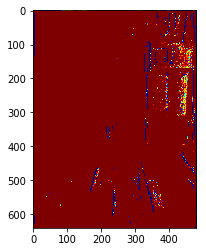

In [147]:
predicted_depth = predicted_depth / np.max(predicted_depth)
plt.imshow(predicted_depth, cmap='jet')

2.609266